<a href="https://colab.research.google.com/github/fariszahid002/CSC3632_Practical1/blob/main/Dissertation_Visualization.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Dissertation - VIsualization of Missing Values Using Clustering and Correlation

## Data Preprocessing

In [53]:
# Loading in standard packages for analysis and visualization
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import torch
import scipy

# Load dataset
df = pd.read_csv(r"/content/Ship_Dataset_with_MAR_and_MNAR_Missingness.csv")

In [ ]:
if torch.cuda.is_available():
    print('Using GPU, device name:', torch.cuda.get_device_name(0))
    device = torch.device('cuda')
else:
    print('No GPU found, using CPU instead.')
    device = torch.device('cpu')

Using GPU, device name: Tesla T4


In [ ]:
# Examining first 10 rows of the dataset
df.head(10)

,Date,Ship_Type,Route_Type,Engine_Type,Maintenance_Status,Speed_Over_Ground_knots,Engine_Power_kW,Distance_Traveled_nm,Draft_meters,Weather_Condition,Cargo_Weight_tons,Operational_Cost_USD,Revenue_per_Voyage_USD,Turnaround_Time_hours,Efficiency_nm_per_kWh,Seasonal_Impact_Score,Weekly_Voyage_Count,Average_Load_Percentage
0,2023-06-04,Container Ship,NaN,Heavy Fuel Oil (HFO),Critical,12.597558,2062.983982,1030.943616,14.132284,Moderate,1959.017882,NaN,292183.273104,25.867077,1.455179,1.415653,1,93.769249
1,2023-06-11,Fish Carrier,Short-haul,Steam Turbine,Good,10.387580,1796.057415,1060.486382,14.653083,Rough,162.394712,NaN,883765.787360,63.248196,0.290361,0.885648,6,93.895372
2,2023-06-18,Container Ship,Long-haul,Diesel,Fair,20.749747,1648.556685,658.874144,7.199261,Moderate,178.040917,NaN,394018.746904,49.418150,0.499595,1.405813,9,96.218244
3,2023-06-25,Bulk Carrier,Transoceanic,Steam Turbine,Fair,21.055102,915.261795,1126.822519,11.789063,Moderate,1737.385346,261349.605449,87551.375175,22.409110,0.702906,1.370704,1,66.193698
4,2023-07-02,Fish Carrier,Transoceanic,Diesel,Fair,13.742777,1089.721803,1445.281159,9.727833,Moderate,260.595103,287718.375160,676121.459632,64.158231,1.331343,0.583383,8,80.008581
5,2023-07-09,Fish Carrier,Long-haul,Heavy Fuel Oil (HFO),Fair,18.616196,2171.646567,723.304215,14.916320,Rough,1912.509751,184569.045384,776698.354849,47.476155,1.370206,1.437725,7,53.174898
6,2023-07-16,Fish Carrier,Transoceanic,Heavy Fuel Oil (HFO),Critical,20.433119,2505.043509,270.118588,8.455264,Rough,1191.436412,NaN,739431.825390,29.040420,1.120389,0.602932,3,58.508635
7,2023-07-23,Container Ship,Short-haul,Diesel,Critical,23.498048,814.806452,1717.328413,9.283780,Moderate,318.449265,348380.608232,462211.402199,52.478600,0.695975,1.408663,6,94.591972
8,2023-07-30,NaN,Coastal,Heavy Fuel Oil (HFO),Good,17.309362,1179.018805,429.564313,6.002358,Moderate,1953.447929,346071.519942,448682.864128,14.451820,0.977448,0.764914,8,50.247060
9,2023-08-06,Container Ship,Long-haul,Diesel,Fair,23.227101,2685.401654,1588.792282,11.721261,Calm,1843.438252,149790.209291,615230.857491,63.742761,0.440676,1.435569,2,79.451330


In [ ]:
# Understanding data types
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2736 entries, 0 to 2735
Data columns (total 18 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   Date                     2736 non-null   object 
 1   Ship_Type                2600 non-null   object 
 2   Route_Type               2600 non-null   object 
 3   Engine_Type              2600 non-null   object 
 4   Maintenance_Status       2600 non-null   object 
 5   Speed_Over_Ground_knots  2736 non-null   float64
 6   Engine_Power_kW          2736 non-null   float64
 7   Distance_Traveled_nm     2736 non-null   float64
 8   Draft_meters             2736 non-null   float64
 9   Weather_Condition        2600 non-null   object 
 10  Cargo_Weight_tons        2093 non-null   float64
 11  Operational_Cost_USD     2052 non-null   float64
 12  Revenue_per_Voyage_USD   2736 non-null   float64
 13  Turnaround_Time_hours    2736 non-null   float64
 14  Efficiency_nm_per_kWh   

In [ ]:
# Checking for missing values in the dataset
print(df.isnull().sum())

Date                         0
Ship_Type                  136
Route_Type                 136
Engine_Type                136
Maintenance_Status         136
Speed_Over_Ground_knots      0
Engine_Power_kW              0
Distance_Traveled_nm         0
Draft_meters                 0
Weather_Condition          136
Cargo_Weight_tons          643
Operational_Cost_USD       684
Revenue_per_Voyage_USD       0
Turnaround_Time_hours        0
Efficiency_nm_per_kWh        0
Seasonal_Impact_Score        0
Weekly_Voyage_Count          0
Average_Load_Percentage      0
dtype: int64


Converting to binary matrix
- Things to consider:
  - Does it facilitate loss of any important information? (If yes, does it matter? Would it affect analysis?)
  - When converting to binary matrix, how does it differ from previous implementation by Wang where they use data classification?

In [32]:
# Convert missing values into a binary matrix
binary_missing = df.isnull().astype(int)

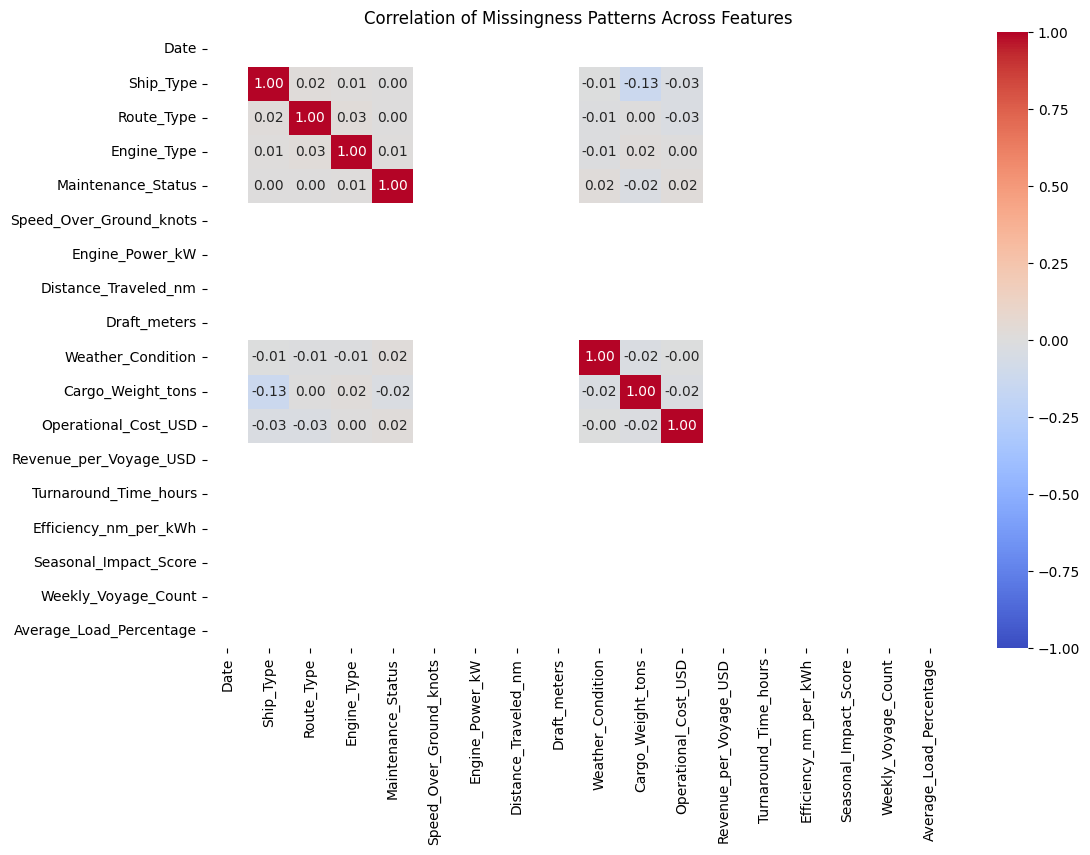

In [3]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# Create a binary missingness matrix
binary_missing = df.isnull().astype(int)

# Compute the correlation matrix of missingness patterns
missingness_corr = binary_missing.corr()

# Plot the heatmap
plt.figure(figsize=(12, 8))
sns.heatmap(missingness_corr, annot=True, cmap='coolwarm', fmt=".2f", vmin=-1, vmax=1)
plt.title('Correlation of Missingness Patterns Across Features')
plt.show()

In [ ]:
# Display the first 10 rows of the binary matrix dataset
binary_missing.head(10)

In [ ]:
print(binary_missing.nunique(axis=0))  # Count unique missingness patterns per feature (test)

Age                      1
Gender                   1
Education Level          1
Marital Status           1
Income                   2
Credit Score             2
Loan Amount              2
Loan Purpose             1
Employment Status        1
Years at Current Job     1
Payment History          1
Debt-to-Income Ratio     1
Assets Value             2
Number of Dependents     2
City                     1
State                    1
Country                  1
Previous Defaults        2
Marital Status Change    1
Risk Rating              1
dtype: int64


## Hierarchical Clustering

Source:

1) https://www.analyticsvidhya.com/blog/2019/05/beginners-guide-hierarchical-clustering/#h-what-is-hierarchical-clustering


### Feature-level missingness pattern Dendogram

<Axes: >

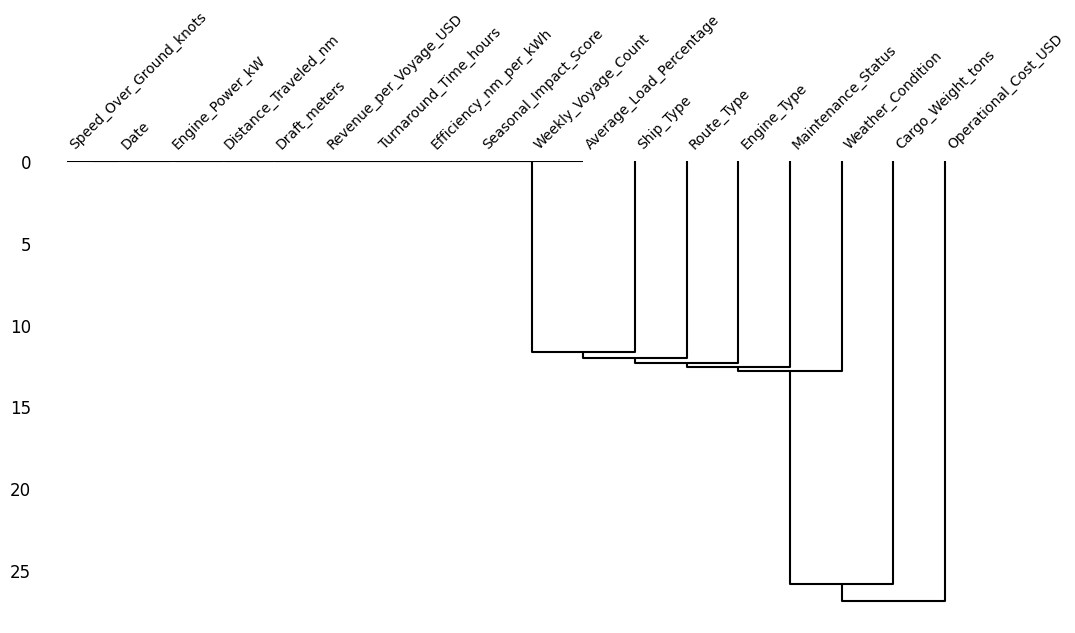

In [4]:
import missingno as msno

msno.dendrogram(df, figsize=(12, 6), fontsize=10)

In [33]:
from scipy.cluster.hierarchy import linkage

# Hierarchical clustering on binary dataset
Z = linkage(binary_missing, method='ward')

- Another thing to consider is to use a distance metric Jaccard. This is suitable for binary matrix.

### Row-level missingness patterns Dendogram

- We choose the number of clusters through visualizing missing values through a dendogram. The dendogram visualizes hierarchical clustering but does not actually assign cluster labels to the observations.

- We cut the dendogram at an appropriate height (cuts the tallest vertical line before they merge) to find the number of clusters.


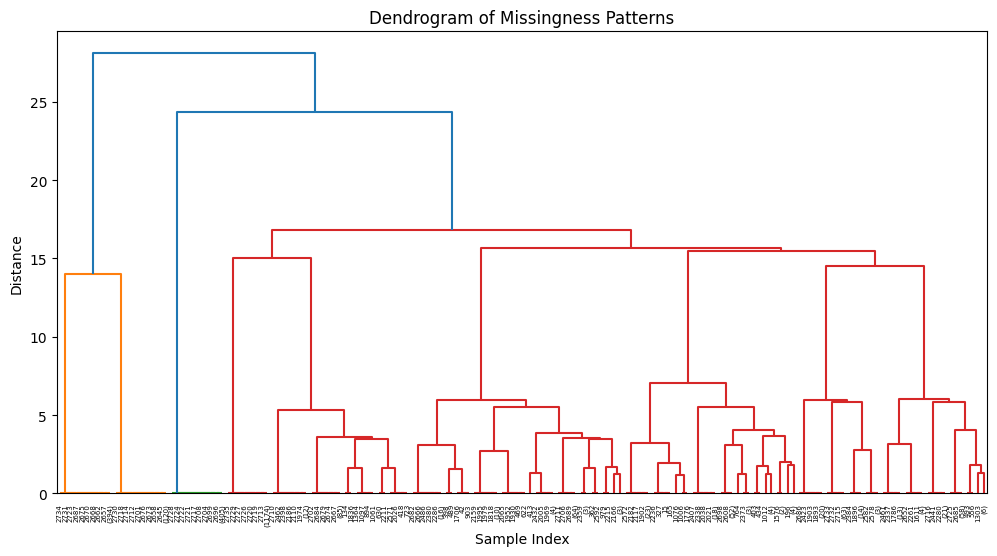

In [34]:
from scipy.cluster.hierarchy import dendrogram

# Plotting the dendogram
plt.figure(figsize=(12, 6))
dendrogram(Z, truncate_mode='level', p=10) # Truncate the dendrogram to show only 3 levels
plt.title("Dendrogram of Missingness Patterns")
plt.xlabel("Sample Index")
plt.ylabel("Distance")
# plt.axhline(y=40, color='r', linestyle='--')
plt.show()

What can we tell from this dendogram visualization?
- Shows relationships between missingness patterns whereby missing values that have similar profiles will be grouped together.
- Can see which variable contribute to missing patterns by examining clusters...?

In [35]:
from scipy.cluster.hierarchy import fcluster

# Setting cut-off threshold
cut_off = 40  # Adjust based on dendrogram height
num_clusters = fcluster(Z, cut_off, criterion="distance")

# Counting the number of clusters formed
import numpy as np
print(f"Number of clusters: {len(np.unique(num_clusters))}")

Number of clusters: 1


- Below perform hierarchical clustering that actually assigns cluster label to each observation (row).
- This is necessary because the dendogram alone does not provide clusters, it only shows potential cluster structures.
- Instead of analyzing a complex tree structure, we assign each row (observation) into one of 7 missingness-based clusters and then analyze their patterns systematically.

cluster_summary
- Instead of analyzing missingness across the entire dataset, we now compare clusters separately.

In [36]:
from sklearn.cluster import AgglomerativeClustering
import seaborn as sns
import matplotlib.pyplot as plt

# Perform hierarchical clustering with k clusters
num_clusters = 4  # Adjust the number of clusters as needed
hc = AgglomerativeClustering(n_clusters=num_clusters, linkage="ward")
cluster_labels = hc.fit_predict(binary_missing)

# Add the cluster labels to the dataset
df['Hierarchical_Cluster'] = cluster_labels

# Calculate missingness rates per cluster
missingness_rates = df.groupby('Hierarchical_Cluster').apply(lambda x: x.isnull().mean())

<ipython-input-36-236286d023c6>:14: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  missingness_rates = df.groupby('Hierarchical_Cluster').apply(lambda x: x.isnull().mean())


In [37]:
# Creating a DataFrame to summarize missing values per cluster
cluster_summary = df.groupby("Hierarchical_Cluster").apply(lambda x: x.isnull().sum())

# Convert counts to proportions (percentage of missing values per feature)
cluster_summary_percentage = cluster_summary.div(cluster_summary.sum(axis=1), axis=0) * 100

cluster_summary

<ipython-input-37-78943f90c71b>:2: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  cluster_summary = df.groupby("Hierarchical_Cluster").apply(lambda x: x.isnull().sum())


,Date,Ship_Type,Route_Type,Engine_Type,Maintenance_Status,Speed_Over_Ground_knots,Engine_Power_kW,Distance_Traveled_nm,Draft_meters,Weather_Condition,Cargo_Weight_tons,Operational_Cost_USD,Revenue_per_Voyage_USD,Turnaround_Time_hours,Efficiency_nm_per_kWh,Seasonal_Impact_Score,Weekly_Voyage_Count,Average_Load_Percentage,Hierarchical_Cluster
Hierarchical_Cluster,,,,,,,,,,,,,,,,,,,
0,0,16,136,136,130,0,0,0,0,130,111,119,0,0,0,0,0,0,0
1,0,120,0,0,6,0,0,0,0,6,0,22,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,0,414,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,532,129,0,0,0,0,0,0,0


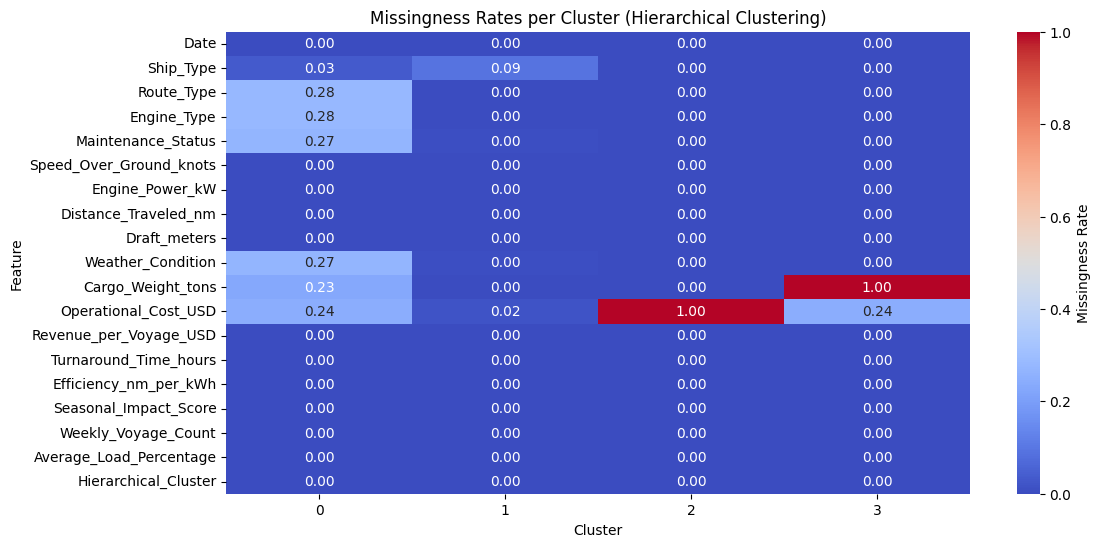

In [38]:
# Visualize missingness rates using a heatmap
plt.figure(figsize=(12, 6))
sns.heatmap(missingness_rates.T, annot=True, cmap='coolwarm', fmt=".2f", cbar_kws={'label': 'Missingness Rate'})
plt.title('Missingness Rates per Cluster (Hierarchical Clustering)')
plt.xlabel('Cluster')
plt.ylabel('Feature')
plt.show()

- TSNE - ideal to visualize high-dimensional data

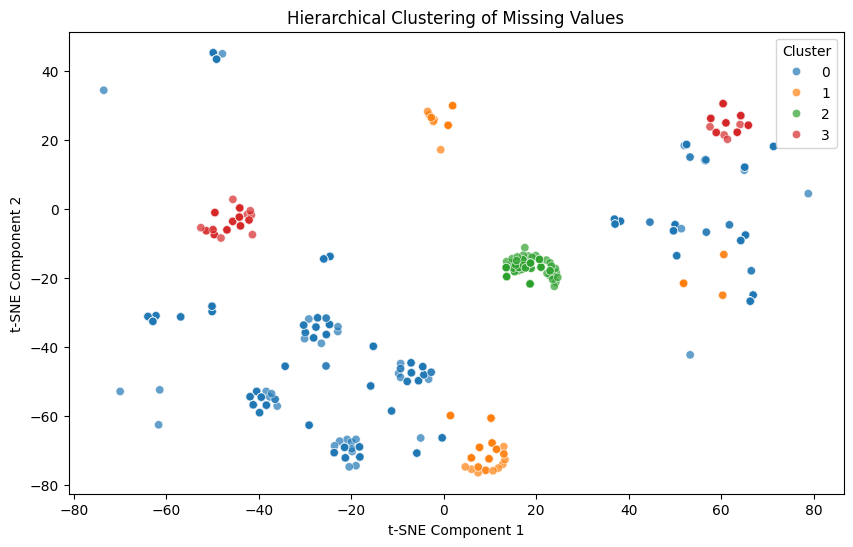

In [39]:
from sklearn.manifold import TSNE

# Visualizing missing values using TSNE
tsne = TSNE(n_components=2, perplexity=30, random_state=42)
tsne_results = tsne.fit_transform(binary_missing)

tsne_df = pd.DataFrame(tsne_results, columns=["tSNE1", "tSNE2"])
tsne_df["Hierarchical_Cluster"] = cluster_labels  # Use Agglomerative clustering labels

# Creating scatter plot
plt.figure(figsize=(10, 6))
sns.scatterplot(x="tSNE1", y="tSNE2", hue="Hierarchical_Cluster", data=tsne_df, palette="tab10", alpha=0.7)
plt.title("Hierarchical Clustering of Missing Values")
plt.xlabel("t-SNE Component 1")
plt.ylabel("t-SNE Component 2")
plt.legend(title="Cluster")
plt.show()


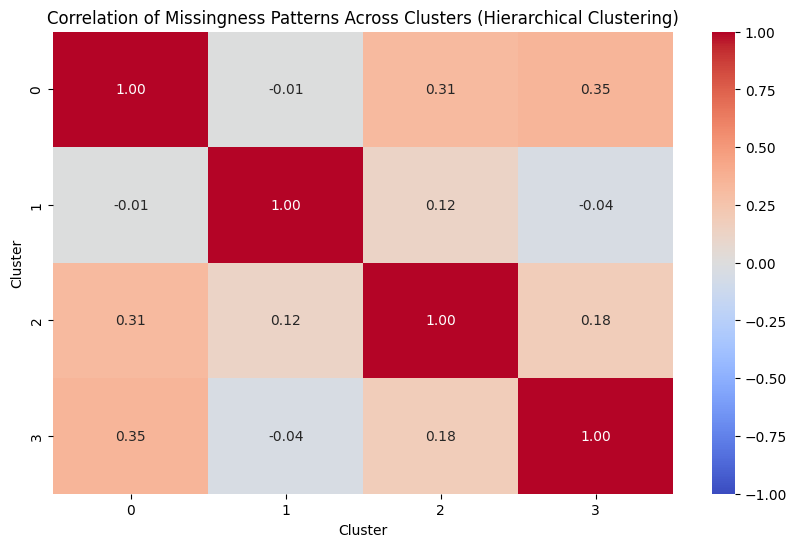

In [40]:
# Correlation between clusters
cluster_missingness_corr = missingness_rates.T.corr()

# Plot the heatmap of correlation of missingness across clusters
plt.figure(figsize=(10, 6))
sns.heatmap(cluster_missingness_corr, annot=True, cmap='coolwarm', fmt=".2f", vmin=-1, vmax=1)
plt.title('Correlation of Missingness Patterns Across Clusters (Hierarchical Clustering)')
plt.xlabel("Cluster")
plt.ylabel("Cluster")
plt.show()

## Density Based Spatial Clustering of Applications with Noise (DBSCAN) Clustering

- Two parematers that needs to be known
  - Radius of neighborhoods for a given data point p (denoted as epsilon)
  - The min number of data points in a given e-neighborhood to form clusters (denoted as minPts)
    - Points that do not meet this criterion are classified as noise / outliers



Source:

1) https://www.reneshbedre.com/blog/dbscan-python.html

2) https://www.analyticsvidhya.com/blog/2020/09/how-dbscan-clustering-works/



### Finding optimal Epsilon value using K-Distance Plot

Method: Temporary Imputation
- Missing values are temporarily imputed using a simple and straightforward imputation technique (mean)
- This is done to ONLY determine eps, will not be used for DBSCAN clustering
- The point where there is the maximum curvature will be chosen as the elbow value.


Source:

1) https://medium.com/leukemiaairesearch/dbscan-and-gaussian-mixtures-with-gene-expression-data-87d1c7cddb59


<ipython-input-54-b1d637b7c760>:32: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


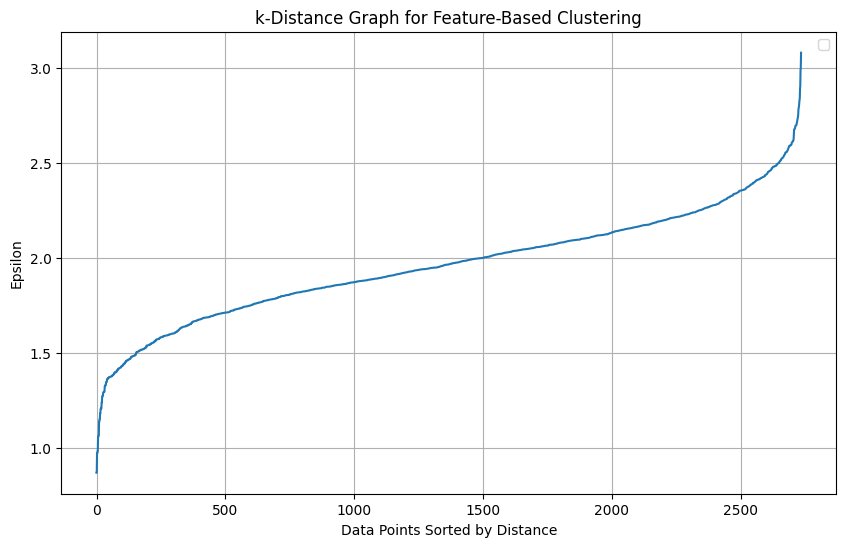

Suggested eps value: 2.0


In [54]:
import pandas as pd
import numpy as np
from sklearn.neighbors import NearestNeighbors
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt

# Selecting only numerical features (since missing values in dataset are numerical)
numeric_features = df.select_dtypes(include=[np.number]).columns
df_numeric = df[numeric_features]

# Temporarily imputing missing values with mean (for distance calculation only)
df_imputed = df_numeric.copy().fillna(df_numeric.mean())

# Standardize dataset
scaler = StandardScaler()
df_scaled = scaler.fit_transform(df_imputed)

# Finding optimal eps using k-distance graph
neighbors = NearestNeighbors(n_neighbors=34)
neighbors_fit = neighbors.fit(df_scaled)
distances, indices = neighbors_fit.kneighbors(df_scaled)

sorted_distances = np.sort(distances[:,1])

# Plotting k-distance graph
plt.figure(figsize=(10, 6))
plt.plot(sorted_distances)
plt.title('k-Distance Graph for Feature-Based Clustering')
plt.xlabel('Data Points Sorted by Distance')
plt.ylabel('Epsilon')
# plt.axhline(y=2.0, color='r', linestyle='--', label='Suggested eps')
plt.legend()
plt.grid()
plt.show()

# Use the elbow point from the plot to set eps (CAN BE REMOVED)
suggested_eps = 2.0  # Replace with the optimal value found in the k-distance plot
print(f"Suggested eps value: {suggested_eps}")

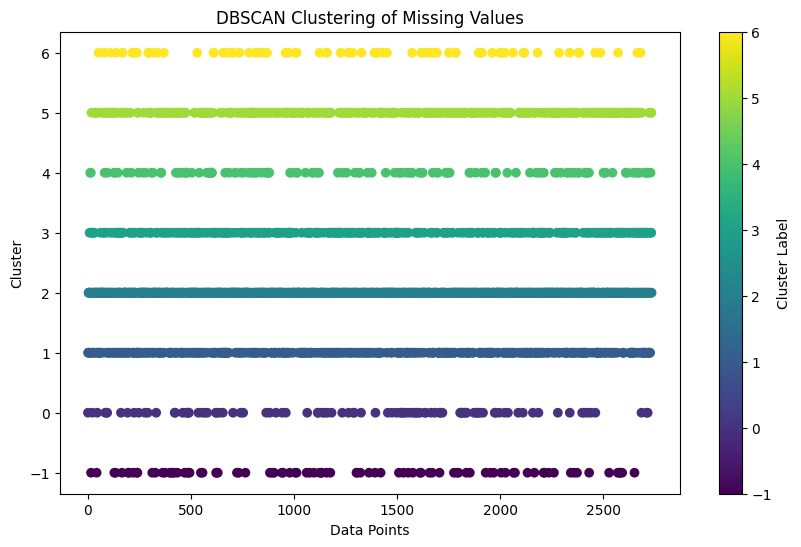

In [55]:
from sklearn.cluster import DBSCAN
from sklearn.metrics import pairwise_distances

# Convert dataset into binary matrix
binary_missing = df.isnull().astype(int)

# Computing pairwise Hamming distances (since data is binary)
hamming_distances = pairwise_distances(binary_missing, metric="hamming")

# Apply DBSCAN clustering
dbscan = DBSCAN(eps=2.4, min_samples=34)
clusters = dbscan.fit_predict(hamming_distances)

# Add the cluster labels to the original dataset
df['DBSCAN_Cluster'] = clusters

# Visualize the clusters of missing values
plt.figure(figsize=(10, 6))
plt.scatter(range(len(df)), df['DBSCAN_Cluster'], c=df['DBSCAN_Cluster'], cmap='viridis', marker='o')
plt.title('DBSCAN Clustering of Missing Values')
plt.xlabel('Data Points')
plt.ylabel('Cluster')
plt.colorbar(label='Cluster Label')
plt.show()

In [56]:
# Creating a DataFrame to summarize missing values per cluster
cluster_summary = df.groupby("DBSCAN_Cluster").apply(lambda x: x.isnull().sum())

# Convert counts to proportions (percentage of missing values per feature)
cluster_summary_percentage = cluster_summary.div(cluster_summary.sum(axis=1), axis=0) * 100

cluster_summary

<ipython-input-56-695da1b8008a>:2: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  cluster_summary = df.groupby("DBSCAN_Cluster").apply(lambda x: x.isnull().sum())


,Date,Ship_Type,Route_Type,Engine_Type,Maintenance_Status,Speed_Over_Ground_knots,Engine_Power_kW,Distance_Traveled_nm,Draft_meters,Weather_Condition,Cargo_Weight_tons,Operational_Cost_USD,Revenue_per_Voyage_USD,Turnaround_Time_hours,Efficiency_nm_per_kWh,Seasonal_Impact_Score,Weekly_Voyage_Count,Average_Load_Percentage,DBSCAN_Cluster
DBSCAN_Cluster,,,,,,,,,,,,,,,,,,,
-1,0,28,34,33,36,0,0,0,0,30,31,39,0,0,0,0,0,0,0
0,0,18,14,22,24,0,0,0,0,24,0,102,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,0,414,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,0,90,67,54,60,0,0,0,0,66,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,129,129,0,0,0,0,0,0,0
5,0,0,0,0,0,0,0,0,0,0,403,0,0,0,0,0,0,0,0
6,0,0,21,27,16,0,0,0,0,16,80,0,0,0,0,0,0,0,0


<ipython-input-57-df863b4b2640>:4: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  missingness_rates = df.groupby('DBSCAN_Cluster').apply(lambda x: x.isnull().mean())


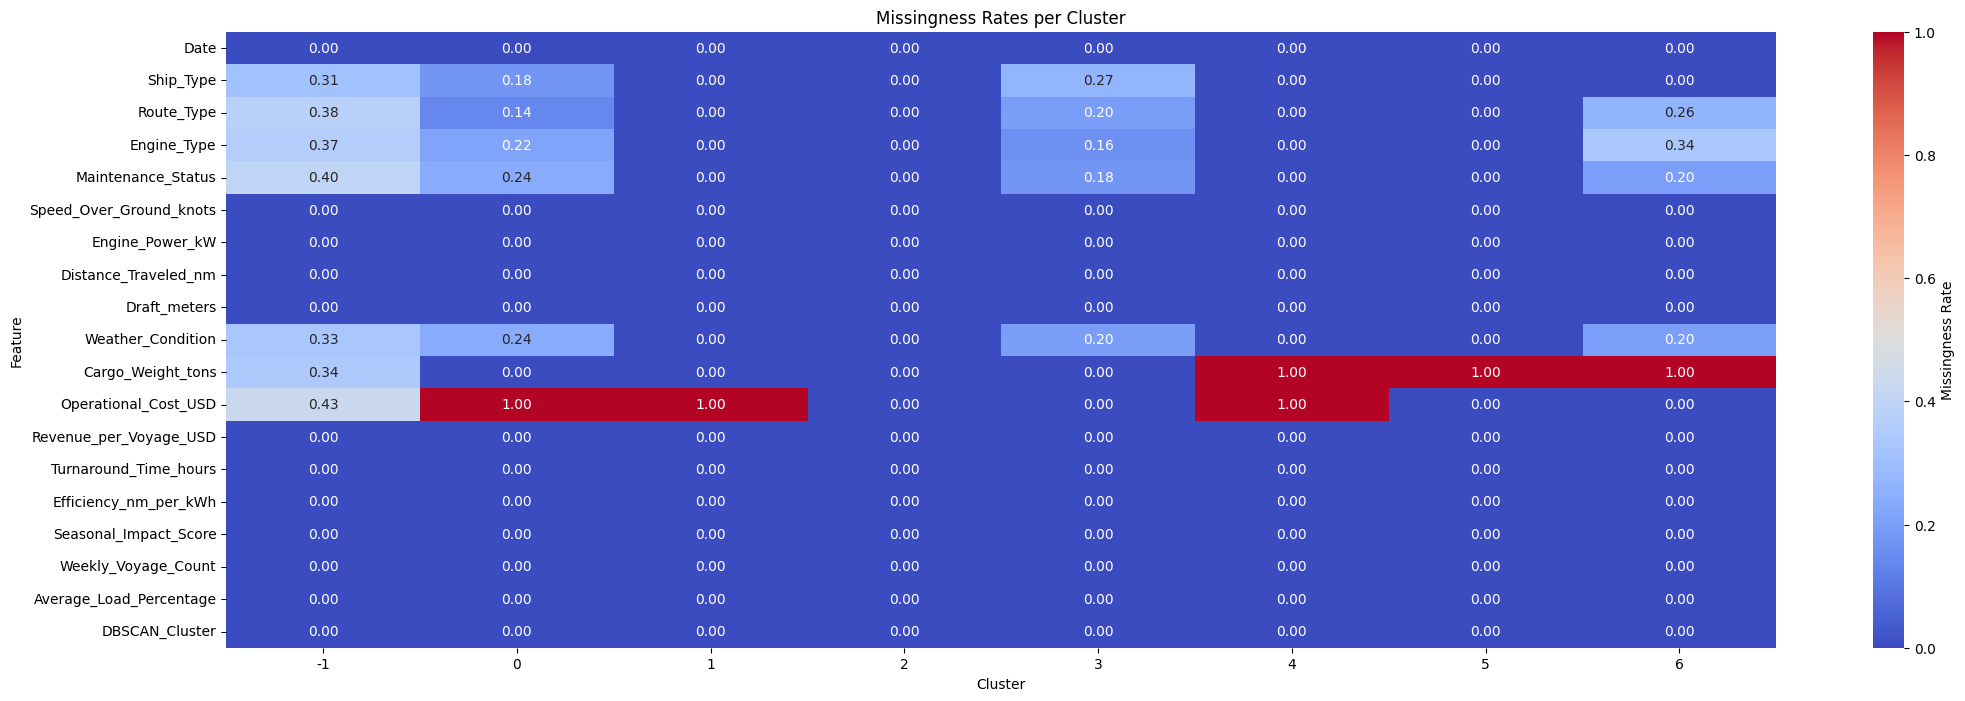

In [57]:
import seaborn as sns

# Calculating missingness rates per cluster
missingness_rates = df.groupby('DBSCAN_Cluster').apply(lambda x: x.isnull().mean())

# Visualize missingness rates using a heatmap
plt.figure(figsize=(25, 8))
sns.heatmap(missingness_rates.T, annot=True, cmap='coolwarm', fmt=".2f", cbar_kws={'label': 'Missingness Rate'})
plt.title('Missingness Rates per Cluster')
plt.xlabel('Cluster')
plt.ylabel('Feature')
plt.show()

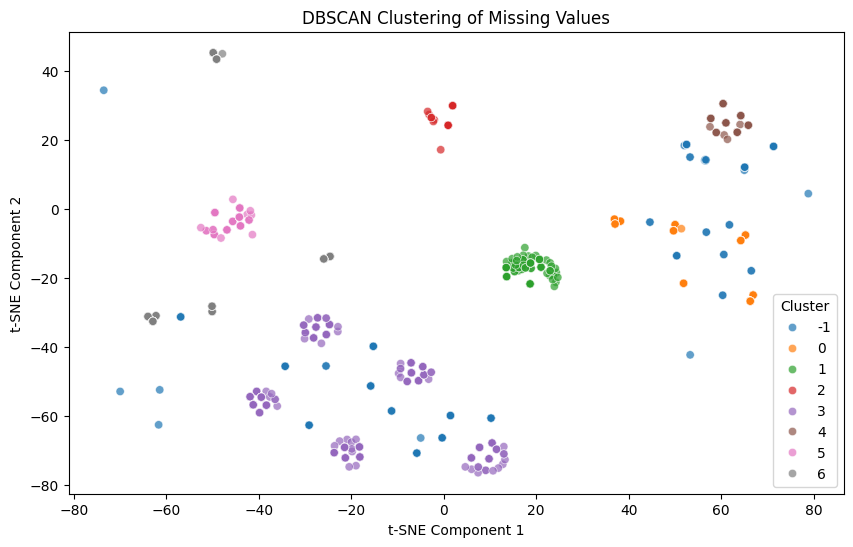

In [58]:
from sklearn.manifold import TSNE
import seaborn as sns

# Visualizing missing values using TSNE
tsne = TSNE(n_components=2, perplexity=30, random_state=42)
tsne_results = tsne.fit_transform(binary_missing)

tsne_df = pd.DataFrame(tsne_results, columns=["tSNE1", "tSNE2"])
tsne_df["DBSCAN_Cluster"] = clusters

# Creating scatter plot
plt.figure(figsize=(10, 6))
sns.scatterplot(x="tSNE1", y="tSNE2", hue="DBSCAN_Cluster", data=tsne_df, palette="tab10", alpha=0.7)
plt.title("DBSCAN Clustering of Missing Values")
plt.xlabel("t-SNE Component 1")
plt.ylabel("t-SNE Component 2")
plt.legend(title="Cluster")
plt.show()

Source: https://www.reneshbedre.com/blog/dbscan-python.html

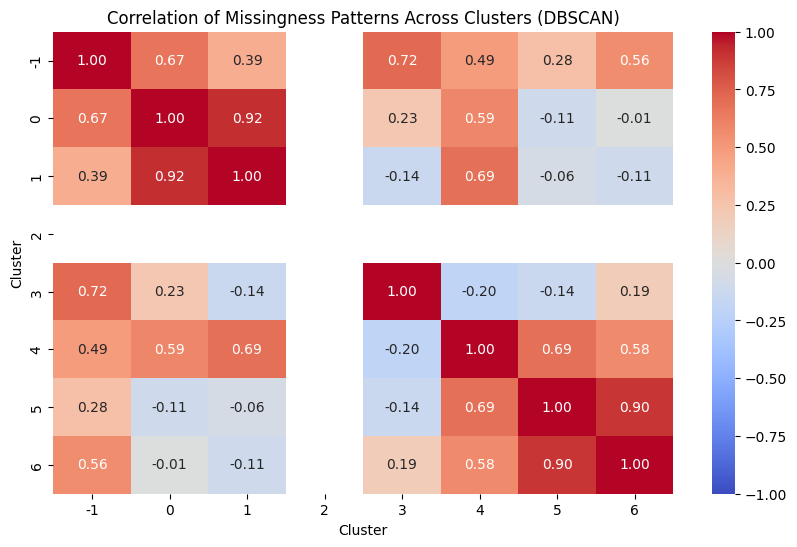

In [59]:
# Correlation between clusters
cluster_missingness_corr = missingness_rates.T.corr()

# Plotting the heatmap of correlation of missingess across clusters
plt.figure(figsize=(10, 6))
sns.heatmap(cluster_missingness_corr, annot=True, cmap='coolwarm', fmt=".2f", vmin=-1, vmax=1)
plt.title('Correlation of Missingness Patterns Across Clusters (DBSCAN)')
plt.xlabel("Cluster")
plt.ylabel("Cluster")
plt.show()


## K-Means Clustering

- Partitioning dataset into a predefined number of clusters
- Optimization plays a crucial role in the k-means clustering algorithm. The goal of the optimization process is to find the best set of centroids that minimizes the sum of squared distances between each data point and its closest centroid.



Sources:

1) https://www.analyticsvidhya.com/blog/2019/08/comprehensive-guide-k-means-clustering/

2) https://hex.tech/blog/Unveiling-patterns-in-unlabeled-data-with-k-means-clustering/


- Using Elbow Method to determine the optimal k value
  - Plots within-cluster sum of squares (WCSS) against the number of clusters
  - Elbow point is identified where the rate of decrease in WCSS begins to slow down

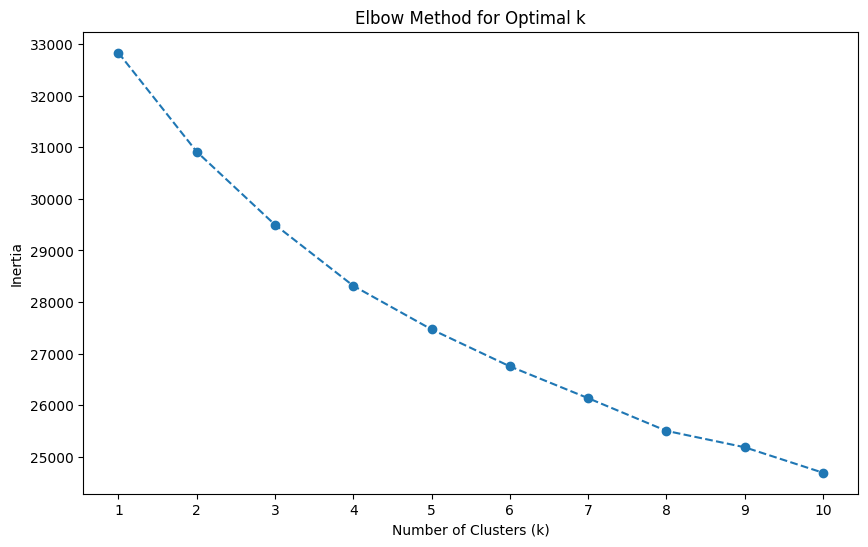

In [60]:
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt
from sklearn.metrics import silhouette_score

# Elbow Method
inertias = []
k_values = range(1, 11)

for k in k_values:
    kmeans = KMeans(n_clusters=k, init='k-means++')
    kmeans.fit(df_scaled) # Scaled data taken from DBSCAN clustering imputation
    inertias.append(kmeans.inertia_)

# Ploting the Elbow Method graph
plt.figure(figsize=(10, 6))
plt.plot(k_values, inertias, marker='o', linestyle='--')
plt.title('Elbow Method for Optimal k')
plt.xlabel('Number of Clusters (k)')
plt.ylabel('Inertia')
plt.xticks(k_values)
plt.show()

- Using Silhoutte Score to determine the optimal k value

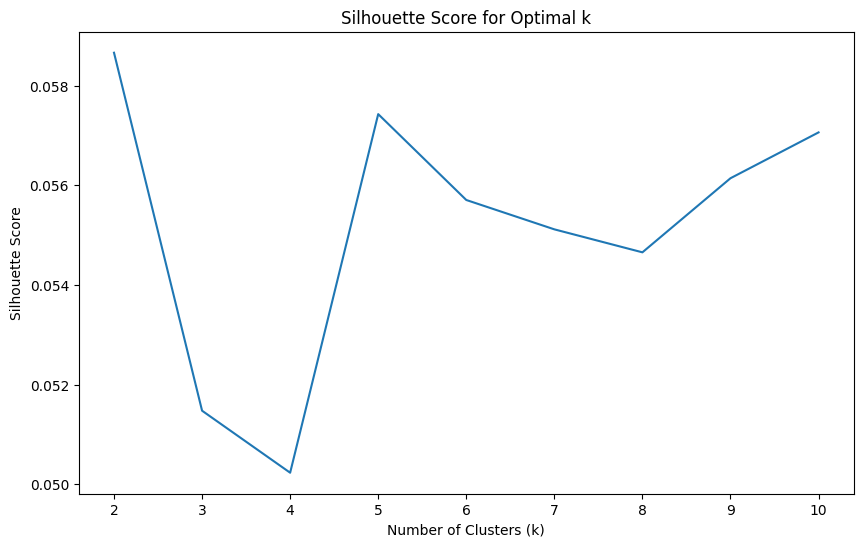

In [19]:
# Silhouette Score
silhouette_scores = []
k_values = range(2, 11)

for k in range(2, 11):
    kmeans = KMeans(n_clusters=k, init='k-means++')
    kmeans.fit(df_scaled)
    score = silhouette_score(df_scaled, kmeans.labels_)
    silhouette_scores.append(score)

# Plotting the Silhouette Score graph
plt.figure(figsize=(10, 6))
plt.plot(range(2, 11), silhouette_scores)
plt.title('Silhouette Score for Optimal k')
plt.xlabel('Number of Clusters (k)')
plt.ylabel('Silhouette Score')
plt.show()

The silhoutte score here neeeds to be re-run multipe times to get a more reliable assessment. Reasons:

- K-means clustering is a randomized algorithm that can produce different cluster assignments and consequently, different silhoutte scores even with the same data and number of clusters.


However, only one method is needed to determine the optimal k-value (either elbow method or silhoutte scores)

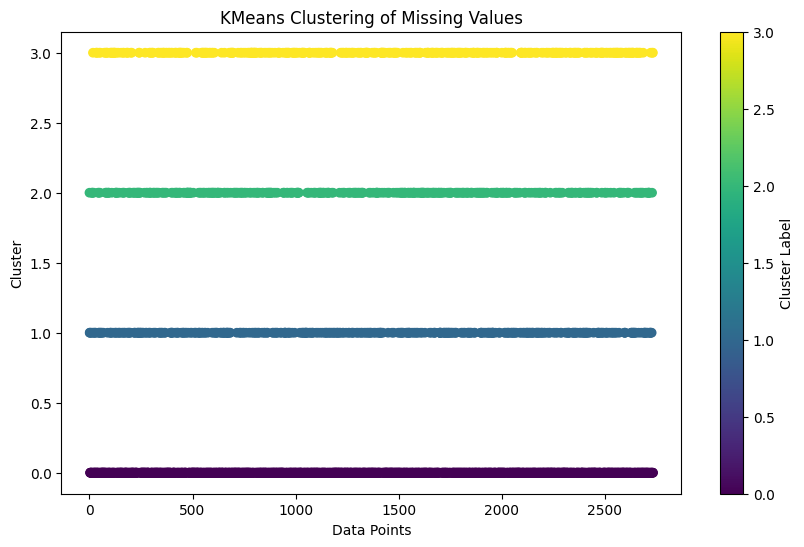

In [61]:
from sklearn.cluster import KMeans
from sklearn.metrics import pairwise_distances

# Convert dataset into binary matrix
binary_missing = df.isnull().astype(int)

# Computing pairwise Hamming distances (since data is binary)
hamming_distances = pairwise_distances(binary_missing, metric="hamming")

# Apply K-Means clustering
num_clusters = 4
kmeans = KMeans(n_clusters=num_clusters, init='k-means++')
clusters = kmeans.fit_predict(hamming_distances)

# Add the cluster labels to the original dataset
df['KMeans_Cluster'] = clusters

# Visualize the clusters of missing values
plt.figure(figsize=(10, 6))
plt.scatter(range(len(df)), df['KMeans_Cluster'], c=df['KMeans_Cluster'], cmap='viridis', marker='o')
plt.title('KMeans Clustering of Missing Values')
plt.xlabel('Data Points')
plt.ylabel('Cluster')
plt.colorbar(label='Cluster Label')
plt.show()

In [62]:
# Creating a DataFrame to summarize missing values per cluster
cluster_summary = df.groupby("KMeans_Cluster").apply(lambda x: x.isnull().sum())

# Convert counts to proportions (percentage of missing values per feature)
cluster_summary_percentage = cluster_summary.div(cluster_summary.sum(axis=1), axis=0) * 100

cluster_summary

<ipython-input-62-d6aabceb99e0>:2: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  cluster_summary = df.groupby("KMeans_Cluster").apply(lambda x: x.isnull().sum())


,Date,Ship_Type,Route_Type,Engine_Type,Maintenance_Status,Speed_Over_Ground_knots,Engine_Power_kW,Distance_Traveled_nm,Draft_meters,Weather_Condition,Cargo_Weight_tons,Operational_Cost_USD,Revenue_per_Voyage_USD,Turnaround_Time_hours,Efficiency_nm_per_kWh,Seasonal_Impact_Score,Weekly_Voyage_Count,Average_Load_Percentage,DBSCAN_Cluster,KMeans_Cluster
KMeans_Cluster,,,,,,,,,,,,,,,,,,,,
0,0,90,67,54,60,0,0,0,0,66,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,0,414,0,0,0,0,0,0,0,0
2,0,46,69,82,76,0,0,0,0,70,240,270,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,403,0,0,0,0,0,0,0,0,0


<ipython-input-63-d20c355c2373>:4: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  missingness_rates = df.groupby('KMeans_Cluster').apply(lambda x: x.isnull().mean())


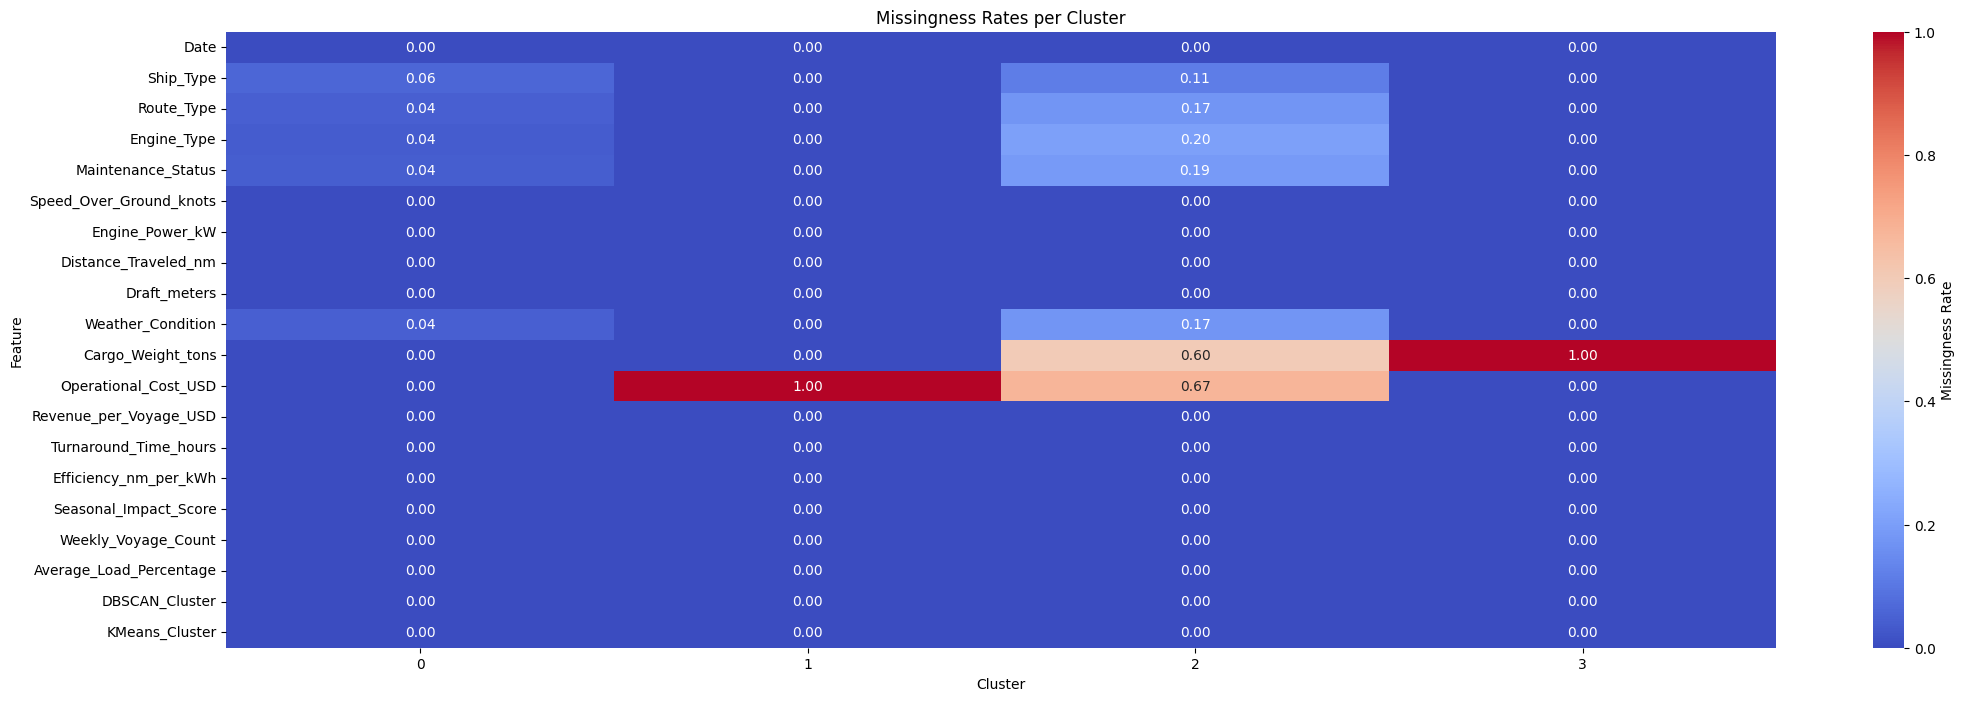

In [63]:
import seaborn as sns

# Calculating missingness rates per cluster
missingness_rates = df.groupby('KMeans_Cluster').apply(lambda x: x.isnull().mean())

# Visualize missingness rates using a heatmap
plt.figure(figsize=(25, 8))
sns.heatmap(missingness_rates.T, annot=True, cmap='coolwarm', fmt=".2f", cbar_kws={'label': 'Missingness Rate'})
plt.title('Missingness Rates per Cluster')
plt.xlabel('Cluster')
plt.ylabel('Feature')
plt.show()

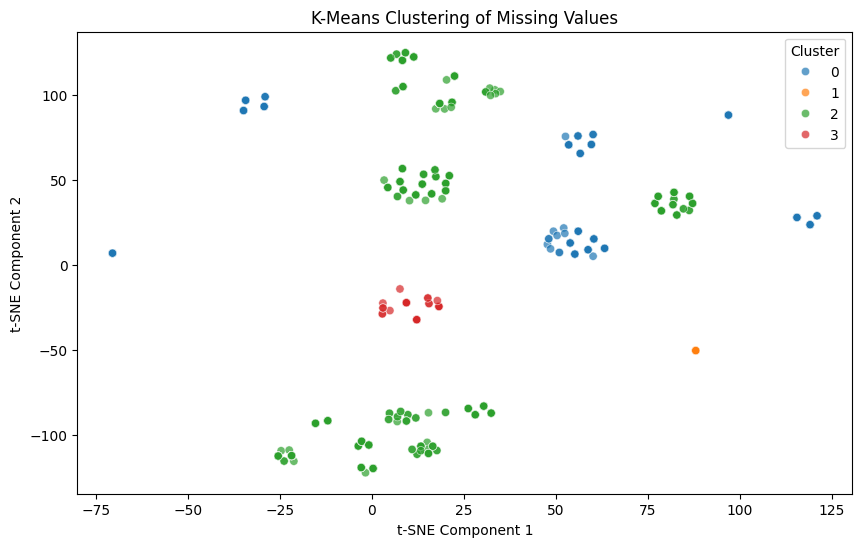

In [64]:
# Visualizing missing values using TSNE
tsne = TSNE(n_components=2, perplexity=30, random_state=42)
tsne_results = tsne.fit_transform(hamming_distances)

tsne_df = pd.DataFrame(tsne_results, columns=["tSNE1", "tSNE2"])
tsne_df["KMeans_Cluster"] = clusters

# Creating scatter plot
plt.figure(figsize=(10, 6))
sns.scatterplot(x="tSNE1", y="tSNE2", hue="KMeans_Cluster", data=tsne_df, palette="tab10", alpha=0.7)
plt.title("K-Means Clustering of Missing Values")
plt.xlabel("t-SNE Component 1")
plt.ylabel("t-SNE Component 2")
plt.legend(title="Cluster")
plt.show()

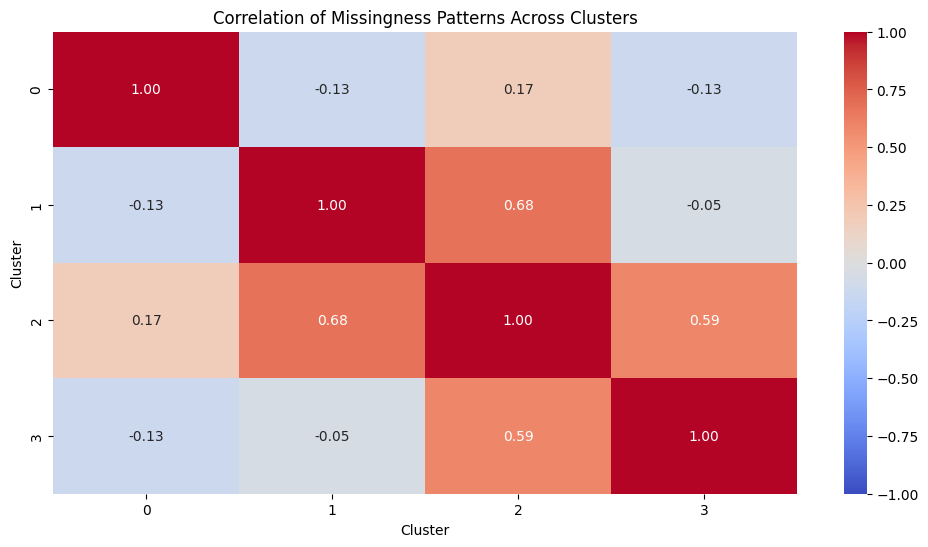

In [65]:
# Correlation between clusters
cluster_missingness_corr = missingness_rates.T.corr()

# Plotting the heatmap of correlation of missingess across clusters
plt.figure(figsize=(12, 6))
sns.heatmap(cluster_missingness_corr, annot=True, cmap='coolwarm', fmt=".2f", vmin=-1, vmax=1)
plt.title('Correlation of Missingness Patterns Across Clusters')
plt.xlabel("Cluster")
plt.ylabel("Cluster")
plt.show()

## Self-Organizing Map (SOM)

Source:

1) https://www.datacamp.com/tutorial/self-organizing-maps - Guidelines on hyper parameter tuning

2) https://www.analyticsvidhya.com/blog/2021/09/beginners-guide-to-anomaly-detection-using-self-organizing-maps/

In [ ]:
!pip install MiniSom

  Preparing metadata (setup.py) ... done
  Created wheel for MiniSom: filename=MiniSom-2.3.5-py3-none-any.whl size=12031 sha256=ec6ee4ec8cfc7e1b2169193bdd6ae068cf9461ece7002c4aadbee4121b116b54
  Stored in directory: /root/.cache/pip/wheels/19/db/95/5e53bc2b88a328217fdf9f2886cafbe86b0df274f4b601f572
Successfully built MiniSom


In [ ]:
from minisom import MiniSom